<a href="https://colab.research.google.com/github/prabal5ghosh/Deep-Learning-summer-school-2025-university-of-cote-d-Azur/blob/main/TPclassifText_SUJET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img width=60% src="http://www.i3s.unice.fr/~lingrand/efeliaUnica.png"><br/><br/>
<font size=+3><b>Text classification - Encoder only</b></font><br/><br/>
<font size=+1>Diane Lingrand, Célia D'cruz and Frédéric Precioso<br/><br/>
    2025 - June/July</font><br/>
    <img width=14% src="http://www.i3s.unice.fr/~lingrand/cc-long.png">
    </center>
    

This lab aims at building from scratch an encoder for text classification. We had to restrict the data used to perform the learning and the architecture drastically in order to be able to run everything in less than 2 hours. This is why we selected:
- a static position embedding (the one that has been used in the paper ['Attention is all you need'](https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf))
- a static attention (cross-product)
- a linear classifier

Another approach to solve this classification problem would be to load a more complex encoder, already learned on another dataset (Bert ...) and finetune it using few epochs on your data.

In [1]:
pip install nltk

In [2]:
# necessary imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import random
import math
import numpy as np
from tqdm import tqdm
import re #regular expressions
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

<font color="red">Use a GPU to speed up computations.</font>
If your laptop does not have a GPU, you can use Google Colab or Kaggle.

To enable GPU backend in Google Colab for your notebook:

1.   Runtime (top left corner) -> Change runtime type
2.   Put GPU as "Hardware accelerator"
3.   Save

Check that your GPU is recognized by running the code below:

In [3]:
# making the code device agnostic
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='cuda')

# Datasets

## Loading the data

In this lab, we will classify the [20 newsgroups dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html). You can easily download the train and test sets using the library scikit-learn. In the next lines of codes, we decided to remove the headers because they are biaised and can help the classification of some of the classes using non appropriate features (domain, protocol version). Our purpose is to classify the texts according to the texts itself. Quotes are also removed.

In [4]:
b_train = fetch_20newsgroups(subset='train', remove=('headers', 'quotes', 'footers'))
b_test = fetch_20newsgroups(subset='test', remove=('headers', 'quotes', 'footers'))

The obtained objects are scikit-learn's [Bunch](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html):

In [5]:
type(b_train)

sklearn.utils._bunch.Bunch

with different keys:

In [6]:
print(b_train.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


The `target_names` are the 20 names of classes that we will learn:

In [7]:
print(b_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


And a global description is available:

In [8]:
print(b_train.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1

Data and labels are lists of, respectively, strings and integers:

In [9]:
print(type(b_train.data), ' of ', len(b_train.data), type(b_train.data[0]))
print(type(b_train.target), ' of ', len(b_train.target), type(b_train.target[0]))


<class 'list'>  of  11314 <class 'str'>
<class 'numpy.ndarray'>  of  11314 <class 'numpy.int64'>


Let's have a look at some random data and labels:

In [10]:
n = random.randint(0,len(b_train.target))
print('Data of label ',b_train.target_names[b_train.target[n]],': ')
print(b_train.data[n])

Data of label  alt.atheism : 

Ahhh go back to alt.autotheism where you belong!


The total length of texts:

In [11]:
np.sum(np.array([len(i) for i in b_train.data]))

np.int64(13781985)

## Splitting the data into train/valid/test

For the learning, we need also a validation dataset that we will extract from the train set:

In [12]:
X_train, y_train = b_train.data, b_train.target
X_test, y_test = b_test.data, b_test.target

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Let's display the distribution of classes in train/valid/test:

In [13]:
def plot_class_distribution(y_train, y_val, y_test, the_class_names):
    number_of_classes = len(np.unique(y_train))

    fig, ax = plt.subplots(layout="constrained")
    for y, name, offset in zip([y_train, y_val, y_test], ["Train", "Val", "Test"], [-0.2, 0, 0.2]):
        rects = ax.bar(np.arange(number_of_classes)+offset, np.bincount(y), 0.2, label=name)
        ax.bar_label(rects)

    ax.set_ylabel("Number of samples")
    ax.set_xlabel("Class number")
    ax.set_title("Distribution of classes")
    ax.set_xticks(np.arange(number_of_classes))
    ax.legend()
    plt.show()


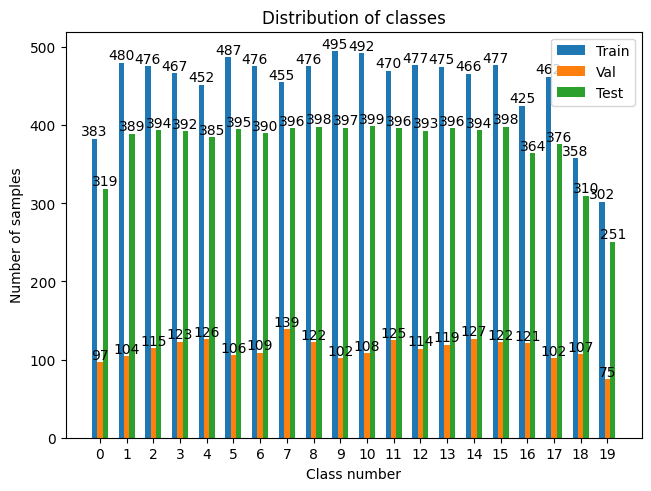

In [14]:
plot_class_distribution(y_train, y_val, y_test, b_train.target_names)

This is almost balanced and every class have roughly the same ratios between train, valid and test.

# Tokenization

Next step is the tokenization. Many algorithms are available. Even for each algorithm, it is possible to build the dictionary/vocabulary adapted to our dataset or to load one that has been already set using a larger dataset. In this notebook, we will focus on the BPE algorithm with your implementation from monday morning:

## homemade BPE tokenisation algorithm

In [17]:
# you can copy/paste your implementation from monday morning here or use the code below

In [18]:
# CORRECTION

class BPETokenizer:
    VOCAB_MAX_LENGTH = 1000 # for construction.

    def computeListOfUniqueWords(self, corpusOfTexts):
        listOfWords = []
        for txt in corpusOfTexts:
            txt = re.sub(r'(\s\s*)',' ',txt) # remove multiple spaces
            listWithSpaces = re.split(r'([,.:;?_!"()\']|--|\s)', txt.lower())
            size = len(listWithSpaces)
            i = 0
            while i < size:
                if listWithSpaces[i]=='\n':
                    listOfWords.append('Ċ')
                elif listWithSpaces[i]==" " and i < size-1 and len(listWithSpaces[i+1])>0 and ('a'<=listWithSpaces[i+1][0]<='z' or '0'<=listWithSpaces[i+1][0]<='9'):
                    listOfWords.append("Ġ"+listWithSpaces[i+1])
                    i += 1
                elif listWithSpaces[i]==" " :
                    i += 1
                elif listWithSpaces[i]:
                    listOfWords.append(listWithSpaces[i])
                i+= 1
        return np.unique(np.array(listOfWords),return_counts=True)

    def initVocabulary(self, listOfWords):
        alphabet = []

        for word in listOfWords:
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)

        alphabet.sort()

        vocab = ["[UNK]"] + alphabet.copy()
        return vocab

    def computePairsAndFreq(self, w,f):
        pairsANDfreqs = defaultdict(int)
        for (word, splittedEl), freq in zip(w.items(),f):
            if len(splittedEl)>1:
                for i in range(len(splittedEl)-1):
                    aPair = (splittedEl[i],splittedEl[i+1])
                    pairsANDfreqs[aPair] += freq
        return pairsANDfreqs

    def mergeApair(self, pair, splittedW, voca, merges):
        if pair != None:
            for word, split in splittedW.items():
                for i in range(len(split)-1):
                    if i < len(split)-1 and split[i]== pair[0] and split[i+1]==pair[1]:
                        newSplit = split[0:i]+[pair[0]+pair[1]]+split[i+2:]
                        split = newSplit
                        splittedW[word]=newSplit
            voca.append(pair[0]+pair[1])
            merges[pair] = pair[0]+pair[1]
        return splittedW, voca, merges

    def mostFreq(self, pairsfreqs):
        freqMax = 0
        pairMax = None
        for p,f in pairsfreqs.items():
            if pairMax == None or f>freqMax:
                pairMax = p
                freqMax = f
        return pairMax

    def computeListOfWords(self, txt):
        listOfWords = []

        txt = re.sub(r'(\s\s*)',' ',txt) # remove multiple spaces
        listWithSpaces = re.split(r'([,.:;?_!"()\']|--|\s)', txt.lower())
        size = len(listWithSpaces)
        i = 0

        while i < size:
            if listWithSpaces[i]=='\n':
                listOfWords.append('Ċ')
            elif listWithSpaces[i]==" " and i < size-1 and len(listWithSpaces[i+1])>0 and ('a'<=listWithSpaces[i+1][0]<='z' or '0'<=listWithSpaces[i+1][0]<='9'):
                listOfWords.append("Ġ"+listWithSpaces[i+1])
                i += 1
            elif listWithSpaces[i]==" ":
                i += 1
            elif listWithSpaces[i]:
                listOfWords.append(listWithSpaces[i])
            i+= 1
            moreSplit = False
        return listOfWords

    # initialisation from a corpus of texts, building vocabulary and merges
    def __init__(self, corpus):
        words, freqs = self.computeListOfUniqueWords(corpus)
        vocab = self.initVocabulary(words)
        splittedWords = {word: [c for c in word] for word in words}
        listOfMerges = {}
        noMorePairs = False
        while len(vocab) < self.VOCAB_MAX_LENGTH and not noMorePairs:
            pairsANDfreqs = self.computePairsAndFreq(splittedWords,freqs)
            pmax = self.mostFreq(pairsANDfreqs)
            if pmax == None:
                noMorePairs = True
            splittedWords, vocab, listOfMerges = self.mergeApair(pmax, splittedWords, vocab, listOfMerges)
        self.token2id = {t:i for i,t in enumerate(vocab)}
        self.id2token = {i:t for t,i in self.token2id.items()}
        self.merges = listOfMerges

    # encode a single text and return
    def encode(self, text):
        pretokenizedText = self.computeListOfWords(text)
        splittedTexts = [[l for l in word] for word in pretokenizedText]
        for pair, merge in self.merges.items():
            for idx, split in enumerate(splittedTexts):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    i += 1
                splittedTexts[idx] = split

        ids = [self.token2id[t] if t in self.token2id else self.token2id["[UNK]"] for s in splittedTexts for t in s]
        return ids

    # decode an encoded text
    def decode(self, ids):
        text = "".join([self.id2token[i] for i in ids])
        text = text.replace("Ġ", " ")
        return text

In order to build a first tokenizer, we suggest to reduce the train dataset. You will use the whole train dataset later in this lab because we will ask you to make few modifications.

In [19]:
reducedTrain = 500
myBPEtokenizer = BPETokenizer(b_train.data[:reducedTrain])

The encodings of each text will be of different sizes. A solution is to truncate the longest texts and to pad the shortest. We first examine the different length of encoding:

In [20]:
listOfLength = []
for txt in tqdm(b_train.data[:reducedTrain]):
    listOfLength.append(len(myBPEtokenizer.encode(txt)))

100%|██████████| 500/500 [00:21<00:00, 22.75it/s]


In the next cell, you can see the plot when we tokenize the reduced train set:

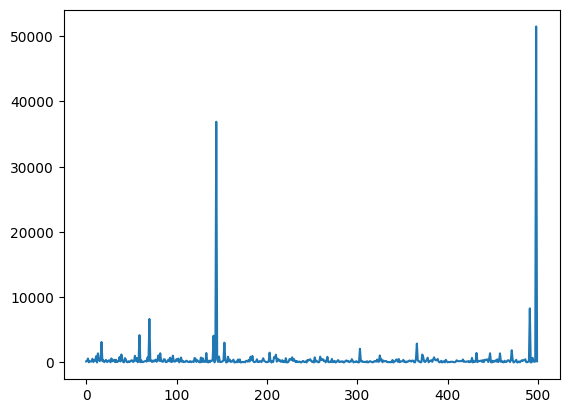

In [21]:
plt.plot(listOfLength)

Why are some texts so long?

In [22]:
themax = np.argwhere(np.array(listOfLength)>40000).squeeze()
print(themax)

498


In [23]:
idx = 498
print(b_train.data[idx], listOfLength[idx])

---------- cut here ---------- part 01/01
begin 644 1260wn31.exe
M35KO 1D    & -$,__\@ P $     ?#_'@     !0V]P>7)I9VAT(#$Y.#DM
M,3DY,"!02U=!4D4@26YC+B!!;&P@4FEG:'1S(%)E<V5R=F5D+@T*        
M        _"Z,#F\$H0( C,N!PP (.\-R RT !BT@ /J\  *.T/LM00"C<02.
MP.B9 *%[!*-Y!*%]!*-W!(S BQY_!+Y_!.AM "ZC<P2[Y &^F +H8 !0OGL$
MO^$!I:6+'GL$BQ9]!(OK@>7_#XK?BOJQ!-/KB]73ZD(KPH[ B\N&Z0,V?P2,
MV@/1CMJ+S8ON,__1Z1//\Z6%VW04_LR.P/[.CMJY  @S_XOU\Z5+Z^B.V#/ 
M4,O1ZXO+T>O1Z]'K0RO#CL S__.EPS/V,]LSTC/_BHPP NA- (J70@*+ZB:(
M3@ FB)X  0/H@?T  7+O0_[-=>2*C#D"Z"H A]^*EX("B^I#0R:(C@ ")HB>
M  ,#Z(']  %R[DO^S77AA_M&@_X)<JW#BNF1L032["0/D;@! -/@PQ(3%%5V
M]\?X>"(3-#4F)W@8%@ "!@X> 1$)&3D%)14U#2UM'5T]?0-#(V,34S-S"TLK
M:QM;.WL'1R=G%U?7-[=W]P^/3\\OKV_O'Y]?WS^_?_\  @$%#0,+&P<7-R]O
M'Y]?WS^_?_\/Z&L +HX>VP&++@  3;X* "Z+/M<!@\<0._5S%3/ K)%!K8O7
M ]".PJV3)@$_XOGKYRZAUP&.P 40 (L> @ #V/J.TXLF! #[ P8( "ZCUP&A
M!@ NH]4!C,".V#/ B]B+R(O0B^B+\(OX+O\NU0$N@S[? 0!U$"Z!/N$!  -W
M!RZ++N$!ZP.]  ,N*2[A 2Z#'M\! "Z.!M<!+HP&W0&_  $S]JVR!Z@!= GH
MC0"J

It's an [uuencoded](https://en.wikipedia.org/wiki/Uuencoding) message!

### truncate and pad

Very long texts in this dataset do not provide useful information for the classification. We will consider only the first 500 tokens and ignore the end of texts longer than 500 tokens. For texts shorter than 500 tokens, we will pad them using a special token: `[PAD]`.

The output of the tokenizer is a dictionary composed of several components that will be forwarded to the model.

* **input_ids**: a list of ids where each token id represents a word or subword.
* **attention_mask**: The attention mask is a binary list indicating the position of the padded indices so that the model does not pay attention to them, as they do not carry any useful information. The model will only focus on tokens that are not padded tokens.

The tokenizer outputs provides the necessary information for the base model.


🤔 <b><font color='purple'>Question:</font></b> Modify the previsous `BPETokenizer` class:
- Add 3 new special tokens: [CLS], [SEP] and [PAD]
    - [CLS] will be added at the beginning of each encoded text
    - [SEP] will be added at the end of each text which encoding is smaller than 500
    - [PAD] will follow [SEP] until the size of 500 is reached
- When padding, construct a mask that is True if padding, False otherwise. Return this mask with the encoding.
- Modify the function `encode` by returning not only the encoding but a tuple composed by the encoding and the mask
- Add a new function for encoding a corpus of texts: `def encodeCorpus(self, corpus)` that will return the list of tuples (encodings,masks) of each texts in the corpus


Example of padding with `TRUNCATE_SIZE=10`:
<pre>
    ['he','lo', 'Ġyou']
      --> [ '[CLS]', 'he','lo', 'Ġyou', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
          [False,False,False, False,False,True,True,True,True,True]
    ['wel','come','Ġto','Ġthe','Ġ2025','Ġde','e','p','Ġlearn','ing','Ġschool']
      --> [ '[CLS]','wel','come','Ġto','Ġthe','Ġ2025','Ġde','e','p','Ġlearn']
          [False,False,False, False,False,False,False,False, False,False]
   </pre>

In [ ]:
# your work

class BPETokenizer:
    VOCAB_MAX_LENGTH = 1000 # for construction.
    TRUNCATE_SIZE = 500

    def computeListOfUniqueWords(self, corpusOfTexts):
        listOfWords = []
        for txt in corpusOfTexts:
            txt = re.sub(r'(\s\s*)',' ',txt) # remove multiple spaces
            listWithSpaces = re.split(r'([,.:;?_!"()\']|--|\s)', txt.lower())
            size = len(listWithSpaces)
            i = 0
            while i < size:
                if listWithSpaces[i]=='\n':
                    listOfWords.append('Ċ')
                elif listWithSpaces[i]==" " and i < size-1 and len(listWithSpaces[i+1])>0 and ('a'<=listWithSpaces[i+1][0]<='z' or '0'<=listWithSpaces[i+1][0]<='9'):
                    listOfWords.append("Ġ"+listWithSpaces[i+1])
                    i += 1
                elif listWithSpaces[i]==" " :
                    i += 1
                elif listWithSpaces[i]:
                    listOfWords.append(listWithSpaces[i])
                i+= 1
        return np.unique(np.array(listOfWords),return_counts=True)

    def initVocabulary(self, listOfWords):
        alphabet = []

        for word in listOfWords:
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)

        alphabet.sort()

        # your work: add 3 other special tokens
        vocab = ["[UNK]"] + alphabet.copy()
        return vocab

    def computePairsAndFreq(self, w,f):
        pairsANDfreqs = defaultdict(int)
        for (word, splittedEl), freq in zip(w.items(),f):
            if len(splittedEl)>1:
                for i in range(len(splittedEl)-1):
                    aPair = (splittedEl[i],splittedEl[i+1])
                    pairsANDfreqs[aPair] += freq
        return pairsANDfreqs

    def mergeApair(self, pair, splittedW, voca, merges):
        if pair != None:
            for word, split in splittedW.items():
                for i in range(len(split)-1):
                    if i < len(split)-1 and split[i]== pair[0] and split[i+1]==pair[1]:
                        newSplit = split[0:i]+[pair[0]+pair[1]]+split[i+2:]
                        split = newSplit
                        splittedW[word]=newSplit
            voca.append(pair[0]+pair[1])
            merges[pair] = pair[0]+pair[1]
        return splittedW, voca, merges

    def mostFreq(self, pairsfreqs):
        freqMax = 0
        pairMax = None
        for p,f in pairsfreqs.items():
            if pairMax == None or f>freqMax:
                pairMax = p
                freqMax = f
        return pairMax

    def computeListOfWords(self, txt):
        listOfWords = []

        txt = re.sub(r'(\s\s*)',' ',txt) # remove multiple spaces
        listWithSpaces = re.split(r'([,.:;?_!"()\']|--|\s)', txt.lower())
        size = len(listWithSpaces)
        i = 0

        while i < size:
            if listWithSpaces[i]=='\n':
                listOfWords.append('Ċ')
            elif listWithSpaces[i]==" " and i < size-1 and len(listWithSpaces[i+1])>0 and ('a'<=listWithSpaces[i+1][0]<='z' or '0'<=listWithSpaces[i+1][0]<='9'):
                listOfWords.append("Ġ"+listWithSpaces[i+1])
                i += 1
            elif listWithSpaces[i]==" ":
                i += 1
            elif listWithSpaces[i]:
                listOfWords.append(listWithSpaces[i])
            i+= 1
            moreSplit = False
        return listOfWords

    # initialisation from a corpus of texts, building vocabulary and merges
    def __init__(self, corpus):
        words, freqs = self.computeListOfUniqueWords(corpus)
        vocab = self.initVocabulary(words)
        splittedWords = {word: [c for c in word] for word in words}
        listOfMerges = {}
        noMorePairs = False
        while len(vocab) < self.VOCAB_MAX_LENGTH and not noMorePairs:
            pairsANDfreqs = self.computePairsAndFreq(splittedWords,freqs)
            pmax = self.mostFreq(pairsANDfreqs)
            if pmax == None:
                noMorePairs = True
            splittedWords, vocab, listOfMerges = self.mergeApair(pmax, splittedWords, vocab, listOfMerges)
        self.token2id = {t:i for i,t in enumerate(vocab)}
        self.id2token = {i:t for t,i in self.token2id.items()}
        self.merges = listOfMerges

    # encode a single text
    # your work: start the encoding with [CLS], truncate at TRUNCATE_SIZE, add [PAD] when needed...
    # return 2 elements: 1st a tensor of token IDs, and 2nd a tensor of attention mask
    def encode(self, text):
        pretokenizedText = self.computeListOfWords(text)
        splittedTexts = [[l for l in word] for word in pretokenizedText]
        for pair, merge in self.merges.items():
            for idx, split in enumerate(splittedTexts):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    i += 1
                splittedTexts[idx] = split

        ids = [self.token2id[t] if t in self.token2id else self.token2id["[UNK]"] for s in splittedTexts for t in s]
        return ids

    # encode a corpus of texts
    # your work: return 2 elements: 1st a tensor of token IDs, and 2nd a tensor of attention mask, both of the size [number of texts in corpus, TRUNCATE_SIZE]
    def encodeCorpus(self, corpus):
        return []

    # decode an encoded text
    # remove [SEP] and [PAD] tokens
    def decode(self, ids):
        text = "".join([self.id2token[i] for i in ids]) # your work : remove CLS token
        text = text.replace("Ġ", " ")
        return text

# Again, debug with a small part of the train set
myBPEtokenizer = BPETokenizer(b_train.data[:reducedTrain])

### Working with the whole train set:

The first option takes some time. Launch the tokenisation and go for a coffee. The code is in the next cell. The second option is to load the tokenizer we saved for you in a file.

In [ ]:
# First option: time for a coffee
myBPEtokenizer = BPETokenizer(b_train.data)
# save your result if you want to restart this session later
with open('myBPEtokenizer.obj', 'wb') as tokenizerFile:
    pickle.dump(myBPEtokenizer, tokenizerFile, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Second option: want to speed up (even with a coffee)
# Download our saved tokenizer
!wget https://www.i3s.unice.fr/~lingrand/myBPEtokenizer.obj
# And load it:
with open('./myBPEtokenizer.obj', 'rb') as tokenizerFile:
    myBPEtokenizer = pickle.load(tokenizerFile)

## Building pytorch Datasets

This part is also time consuming because we will encode the train, valid and test set. The whole code is given. Run 'Option 1' cells if you still need time for a coffee or download the python objects from file if you want to speed up.

In [ ]:
# In any option, run this code that will construct a dataset composed of tokenized texts and binary mask for padding:

class MyCustomDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        assert len(X) == len(y), f"X and y must have the same shape. Got {len(X)} and {len(y)}"
        self.X_tokenized, self.X_attention_mask = tokenizer.encodeCorpus(X)
        self.y = torch.tensor(y, dtype = torch.long)
    def __getitem__(self, idx):
        return ((self.X_tokenized[idx],self.X_attention_mask[idx]), self.y[idx])
    def __len__(self):
        return len(self.y)


In [ ]:
# Option 1

batch_size = 64

train_set = MyCustomDataset(X_train, y_train, myBPEtokenizer)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
with open('train_dataloader.obj', 'wb') as f:
    pickle.dump(train_dataloader, f, pickle.HIGHEST_PROTOCOL)
print('train set done')

val_set = MyCustomDataset(X_val, y_val, myBPEtokenizer)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
with open('val_dataloader.obj', 'wb') as f:
    pickle.dump(val_dataloader, f, pickle.HIGHEST_PROTOCOL)
print('val set done')

test_set = MyCustomDataset(X_test, y_test, myBPEtokenizer)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)
with open('test_dataloader.obj', 'wb') as f:
    pickle.dump(test_dataloader, f, pickle.HIGHEST_PROTOCOL)
print('test set done')

train set done
val set done
test set done


In [ ]:
# Option 2: load dataloder files

!wget https://www.i3s.unice.fr/~lingrand/train_dataloader.obj
!wget https://www.i3s.unice.fr/~lingrand/val_dataloader.obj
!wget https://www.i3s.unice.fr/~lingrand/test_dataloader.obj
with open('train_dataloader.obj', 'rb') as f:
    train_dataloader = pickle.load(f)
with open('val_dataloader.obj', 'rb') as f:
    val_dataloader = pickle.load(f)
with open('test_dataloader.obj', 'rb') as f:
    test_dataloader = pickle.load(f)


You can observe a batch of data this way:

In [ ]:
input_batch, target_batch = next(iter(train_dataloader))

In [ ]:
print(input_batch)

In [ ]:
print(target_batch)

# Embedings and model

Embeddings are composed of :
- token embeddings
- position embeddings

We will learn the tokens embeddings (an array of dimension: the number of tokens in the dictionary and the embedding dimension).

For the position embeddings, we could use learnable embeddings using the number of possible positions (`TRUNCATE_SIZE`) but we chose instead to use static position embeddings in order to reduce the number of parameters to learn.

We choose an embedding dimension of 64:

In [ ]:
hiddenDimEmb = 64

## Tokens embeddings

🤔 <b><font color='purple'>Question:</font></b> Build a layer in charge of the tokens embeddings using [nn.Embedding](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html). Apply this embedding to one of the data from the previous `input_batch`.

In [ ]:
# hint1:
# one of the dimension of the token embedding is the size of the vocabulary, which is also the size of token2id instance variable.

In [ ]:
# hint2:
# you can have access to the first tokenized text of the input_batch this way: input_batch[0][0]

In [ ]:
# your work
sizeDico = ...
embedDico = ...

## Position embeddings

🤔 <b><font color='purple'>Question:</font></b> What is the number of positions inside a tokenized text? How would you set a learnable layer for position embeddings?

In [ ]:
# your work
nbPositions = ...
posEmbed = ...

This is the code computing the static position embeddings:

In [ ]:
position = torch.arange(0, nbPositions).unsqueeze(1)
div_term = torch.exp(torch.arange(0, hiddenDimEmb, 2) * ( - math.log(10000.0) / hiddenDimEmb))
sinusoidal_positional_encoding = torch.empty(nbPositions, hiddenDimEmb)
sinusoidal_positional_encoding[:, 0::2] = torch.sin(position * div_term) # even
sinusoidal_positional_encoding[:, 1::2] = torch.cos(position * div_term) # odd
sinusoidal_positional_encoding = sinusoidal_positional_encoding.to(device)

🤔 <b><font color='purple'>Question:</font></b> How to encode the positions of the tokens inside the first tokenized text of `input_batch`?

In [ ]:
#hint1:
# be careful, we encode positions and not tokens!

In [ ]:
# your work

🤔 <b><font color='purple'>Question:</font></b> The global embedding is the sum of tokens embeddings and positions embeddings. Compute the global embedding for the first tokenized text of `input_batch`?

In [ ]:
# your work

## A simple attention model

🤔 <b><font color='purple'>Question:</font></b> The attention is also static in order to reduce the number of parameters to be learned. We will use the simple self attention. Compute the self-attention and the context vector of the same first tokenized text of `input_batch`.

Remember that the self attention of an embedding e is given by softmax(e.eT)e where softmax is defined as:

$ softmax(w)_i = \displaystyle \frac{e^{w_i}}{\sum_j e^{w_j}}$

Be careful that for removing padded tokens, we need to replace the embedding of padded token by `-torch.inf` before the softmax operation, using the [`masked_fill`](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.masked_fill.html) function.

In [ ]:
# your work

## A model for the classification

🤔 <b><font color='purple'>Question:</font></b> Build a model that will perform the classification of the tokenized dataset. Tokens and their positions have to be embedded, self-attention to be computed. A simple Linear layer can be used for the classification as a starting model.

In [ ]:
# your work
class EncoderClassifText(nn.Module):
    def __init__(self, sizeDico, sizePos, hiddenDimEmb=64, nbClasses=20):
        super().__init__()
        self.sizeText = sizePos
# your work

    def forward(self, x):
        data,mask = x
# your work
        return logits

clf = EncoderClassifText(sizeDico,nbPositions).to(device)

Use the next function to count the number of parameters to learn for your model:

In [ ]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(clf)

## Train loop

🤔 <b><font color='purple'>Question:</font></b> Learn and evaluate the previous model. If your model is not learning, you can improve the learning by using dropout, layer normalisation or change any of the previous hyperparameters.

In [ ]:
# your work.

# Another approach: not starting from scratch

In [ ]:
from transformers import AutoTokenizer, AutoModel

We will use a smaller and faster encoder model than BERT - [DistilBERT](https://huggingface.co/distilbert/distilbert-base-cased) - as our base model for both our sequence classification and next sentence prediction models. We load both the base encoder model and its tokenizer.

In [ ]:
base_model_name = "distilbert/distilbert-base-cased" # choosing the pretrained model

tokenizer = AutoTokenizer.from_pretrained(base_model_name) # loading the tokenizer of the corresponding model

base_model = AutoModel.from_pretrained(base_model_name, output_attentions = False) # actually loading the pretrained model

Observe the structure of the base model. There is an embedding layer as well as multiple stacked encoder blocks that include self-attention.

In [ ]:
print(base_model)

Our base model has a maximum sequence length of 512 tokens. Sequences that exceed that limit should be truncated to 512 or less tokens.

In [ ]:
print("maximum sequence length allowed by the base encoder model =", base_model.config.max_position_embeddings)

This a toy example to better understand the tokenization and the model outputs.

In [ ]:
toy_text_list = [
    "This is a first sentence",
    "2nd one",
    "And here is the last sentence..."
]

We tokenize the list of text sequences.

In [ ]:
tokenized_text_list = tokenizer(
    toy_text_list, # list of sequences
    truncation = True, # truncate each sequence to the longuest sequence provided that it is less than the maximum length accepted by the model (512 for our base model)
    padding = True, # add [PAD] tokens to pad each sequence to the longuest sequence, such that each sequence will have the same length
    add_special_tokens = True, # add [CLS] token at the beginning of each sequence, and add [SEP] token at the end of each sequence, those are used by the base model
    return_tensors = "pt" # return the tokenized sequences as pytorch tensors
)

The output of the tokenizer is a dictionary composed of several components that will be inputted to the model.


* **input_ids**: a list of ids where each token id represents a word or subword.
* **attention_mask**: The attention mask is a binary list indicating the position of the padded indices so that the model does not pay attention to them, as they do not carry any useful information. The model will only focus on tokens that have an associated mask value of 1.

The tokenizer outputs provides the necessary information for the base model.


In [ ]:
print(tokenized_text_list)

In [ ]:
for key, value in tokenized_text_list.items():
    print(f"{key} shape: {value.shape}")

This is a similar `Dataset` class:

In [ ]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        assert len(X) == len(y), f"X and y must have the same shape. Got {len(X)} and {len(y)}"
        self.X_tokenized = tokenizer(X, truncation = True, padding = True, add_special_tokens = True, return_tensors = "pt")
        self.y = torch.tensor(y, dtype = torch.long)
    def __getitem__(self, idx):
        X_tokenized_i = {key: val[idx] for key, val in self.X_tokenized.items()}
        y_i = self.y[idx]
        return (X_tokenized_i, y_i)
    def __len__(self):
        return len(self.y)

We define the training loop and the functions necessary to evaluate the sequence classification and next sentence prediction models that we will build in the next sections.

In [ ]:
def train(model, train_dataloader, val_dataloader, nb_epochs, device, optimizer):
    training_validation_loss_history = {"training_loss" : [], "validation_loss" : []}
    model = model.to(device)
    initial_validation_loss = epoch_validation(model, val_dataloader, -1, device)
    for epoch in range(nb_epochs):
        training_loss = epoch_training(model, train_dataloader, epoch, device, optimizer)
        validation_loss = epoch_validation(model, val_dataloader, epoch, device)
        training_validation_loss_history["training_loss"].append(training_loss)
        training_validation_loss_history["validation_loss"].append(validation_loss)
    return training_validation_loss_history

def epoch_training(model, dataloader, epoch, device, optimizer):
    model.train()
    loss_epoch_list = []
    with tqdm(dataloader, unit="batch") as tqdm_dataloader:
        tqdm_dataloader.set_description(f"Epoch {epoch}: Training")
        for input, target in tqdm_dataloader:
            # load tensor to GPU if enabled
            input = {key: val.to(device) for key, val in input.items()}
            target = target.to(device)
            # forward pass
            outputs = model(input, labels = target)
            # get the loss
            loss = outputs["loss"]
            loss_epoch_list.append(loss.item())
            loss_epoch_mean = sum(loss_epoch_list) / len(loss_epoch_list)
            tqdm_dataloader.set_postfix(loss = loss_epoch_mean)
            # backward pass, optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_epoch_mean

def epoch_validation(model, dataloader, epoch, device):
    model.eval()
    loss_epoch_list = []
    with tqdm(dataloader, unit="batch") as tqdm_dataloader, torch.inference_mode():
        tqdm_dataloader.set_description(f"Epoch {epoch}: Validation")
        for input, target in tqdm_dataloader:
            # load tensor to GPU if enabled
            input = {key: val.to(device) for key, val in input.items()}
            target = target.to(device)
            # forward pass
            outputs = model(input, labels = target)
            # get the loss
            loss = outputs["loss"]
            loss_epoch_list.append(loss.item())
            loss_epoch_mean = sum(loss_epoch_list) / len(loss_epoch_list)
            tqdm_dataloader.set_postfix(loss = loss_epoch_mean)
    return loss_epoch_mean

def predict(model, dataloader, device):
    model.eval()
    y_true_list = []
    y_pred_list = []
    with tqdm(dataloader, unit="batch") as tqdm_dataloader, torch.inference_mode():
        tqdm_dataloader.set_description(f"Testing")
        for input, target in tqdm_dataloader:
            # load tensor to GPU if enabled
            input = {key: val.to(device) for key, val in input.items()}
            target = target.to(device)
            # forward pass
            outputs = model(input, labels = target)
            # get true labels and predictions
            y_true_list.extend(target.tolist())
            y_pred_list.extend(outputs["predictions"].tolist())

    accuracy = accuracy_score(y_true_list, y_pred_list)
    return accuracy

## model

Our sequence classification model will be built upon the base encoder model from the previous section, specifically leveraging the contextualized embedding of the [CLS] token. This embedding will be passed to a classification head (a feed-forward neural network) and we will output the predicted class for each sequence. Since we have 20 classes, we will use the torch.nn.CrossEntropyLoss function, which is well-suited for multiclass classification.

In [ ]:
# your work (fill some inputs)

class Sequence_Classification_Model(torch.nn.Module):

    def __init__(self,
        base_model_name,
        number_of_classes,
        train_transformer = True,
        dropout_value = 0.1,
    ):

        super().__init__()
        self.base_model_name = base_model_name
        self.transformer = AutoModel.from_pretrained(...) # base model
        self.embedding_size = self.transformer.config.hidden_size
        self.number_of_classes = number_of_classes
        self.train_transformer = train_transformer
        self.set_transformer_requires_grad(self.train_transformer)

        self.pre_classifier = torch.nn.Linear(self.embedding_size, self.embedding_size)
        self.relu = torch.nn.ReLU()
        self.classifier = torch.nn.Linear(..., ...) # used after the pre_classifier layer, with out_features = number of classes
        self.loss_function = torch.nn.CrossEntropyLoss()

        self.dropout_value = dropout_value
        self.dropout = torch.nn.Dropout(p = self.dropout_value)

    def forward(self, inputs, labels = None): # inputs["input_ids"] dim = [batch_size, number_of_tokens]

        cls_token_embeds = ... # embedding of the contextualized [CLS] token # [batch_size, embed_size]

        pooled_output = self.pre_classifier(cls_token_embeds) # [batch_size, embed_size]
        pooled_output = self.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)

        classifier_output = self.classifier(pooled_output) # classifier_output dim = [batch_size, num_classes]

        predictions = torch.argmax(..., dim = ...) # take the classifier output and get the position of the highest values for each sequence to predict the label # predictions dim = [batch_size]
        loss = self.loss_function(classifier_output, labels)

        return {"loss" : loss, "predictions" : predictions, "classifier_output" : classifier_output}

    def set_transformer_requires_grad(self, state): # boolean: whether to make the transformer part trainable or not
        self.train_transformer = state
        for name, param in self.transformer.named_parameters():
            param.requires_grad = state


We initialize our sequence classification model.

In [ ]:
sequence_classification_model = Sequence_Classification_Model(
    base_model_name,
    len(b_train.target_names),
    train_transformer = True,
    dropout_value = 0.1,
)

We set a few training parameters, which may not be optimal but will still be effective for our task.

In [ ]:
batch_size = 4
nb_epochs = 2
learning_rate = 2e-5
optimizer = torch.optim.AdamW(sequence_classification_model.parameters(), lr = learning_rate)


We create the datasets and dataloaders

In [ ]:
# your code

train_set = MyCustomDataset(X_train, y_train, tokenizer)
val_set = MyCustomDataset(...)
test_set = MyCustomDataset(...)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

Now, we train our sequence classification model. Remember that the defined training parameters are not ideal, and that we used a reduced set of the original dataset. However, you can still see that the model is learning.

In [ ]:
train(sequence_classification_model, train_dataloader, val_dataloader, nb_epochs, device, optimizer)

We show the performance of our trained model by displaying the accuracy on the test set. Note that the score is significantly higher than random predictions.

In [ ]:
accuracy = predict(sequence_classification_model, test_dataloader, device)
print("\naccuracy =", accuracy)